In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import calculate_distance_matrix
from pyclustering.cluster import cluster_visualizer

In [2]:
df = pd.read_csv('adjacency_matrix1.csv', index_col='Id')
df_cluster = df.copy()
df_cluster.head()

,T1566,T1047,T1053,T1059,T1106,T1204,T1543,T1547,T1027,T1036,...,T1005,T1056,T1113,T1560,T1071,T1090,T1105,T1132,T1573,T1041
Id,,,,,,,,,,,,,,,,,,,,,
T1566,0.0,0,0,0.185022,0,0.255507,0,0.004405,0.123348,0.008811,...,0.0,0.0,0.0,0,0.022026,0,0.132159,0,0,0
T1047,0.0,0,0,0.061674,0,0.000000,0,0.000000,0.004405,0.000000,...,0.0,0.0,0.0,0,0.000000,0,0.000000,0,0,0
T1053,0.0,0,0,0.233480,0,0.000000,0,0.000000,0.167401,0.039648,...,0.0,0.0,0.0,0,0.132159,0,0.158590,0,0,0
T1059,0.0,0,0,0.000000,0,0.000000,0,0.000000,0.903084,0.000000,...,0.0,0.0,0.0,0,0.766520,0,1.000000,0,0,0
T1106,0.0,0,0,0.229075,0,0.000000,0,0.000000,0.259912,0.083700,...,0.0,0.0,0.0,0,0.149780,0,0.215859,0,0,0


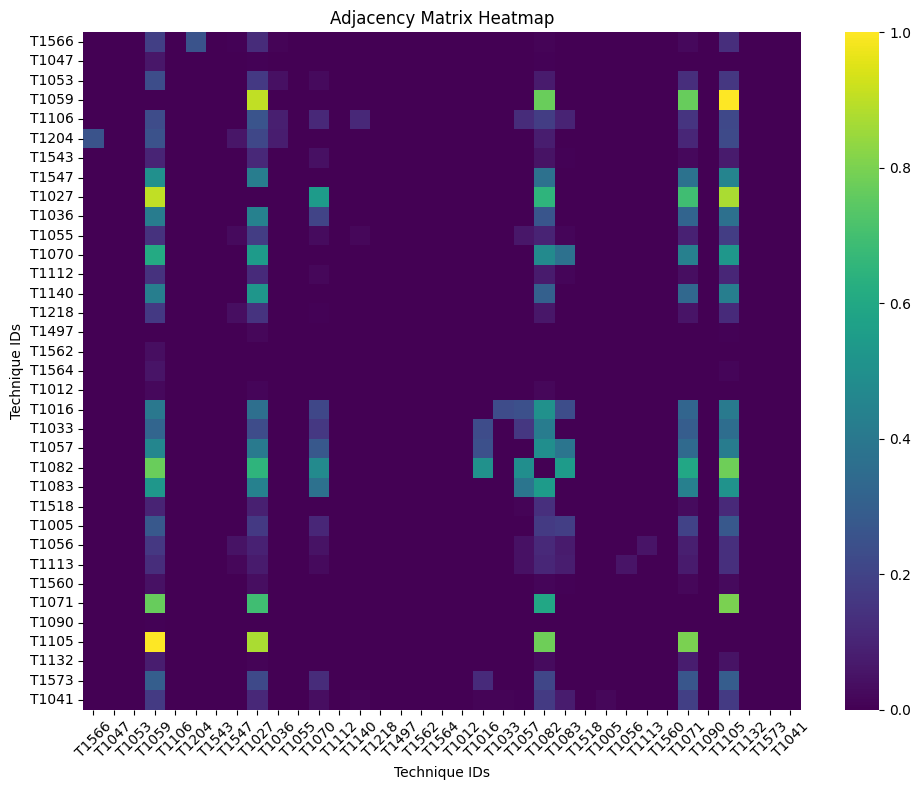

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap='viridis')  # Adjust the colormap as needed
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Technique IDs')
plt.ylabel('Technique IDs')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
sorted_values = sorted(df.values.flatten(), reverse=True)
top_10_values = sorted_values[:10]
chokepoints = df[df.isin(top_10_values)]
for row_label, row in chokepoints.iterrows():
    for col_label, value in row.items():
        if not pd.isnull(value):  # Check if the value is not NaN (i.e., among the top 10 values)
            print(f"Edge: {row_label} - {col_label}, Count: {value}")

Edge: T1059 - T1027, Count: 0.9030837
Edge: T1059 - T1105, Count: 1.0
Edge: T1027 - T1059, Count: 0.9030837
Edge: T1027 - T1105, Count: 0.872246696
Edge: T1082 - T1105, Count: 0.779735683
Edge: T1071 - T1105, Count: 0.797356828
Edge: T1105 - T1059, Count: 1.0
Edge: T1105 - T1027, Count: 0.872246696
Edge: T1105 - T1082, Count: 0.779735683
Edge: T1105 - T1071, Count: 0.797356828


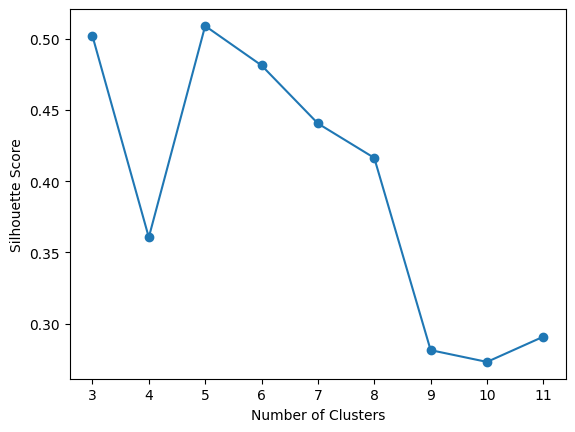

In [6]:
# Apply K-means clustering
k_values = [3,4,5,6,7,8,9,10,11]
silhouette_scores = []
for k in k_values:
    model = KMeans(n_clusters=k)
    df_cluster['kmeans'] = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, df_cluster['kmeans'])
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


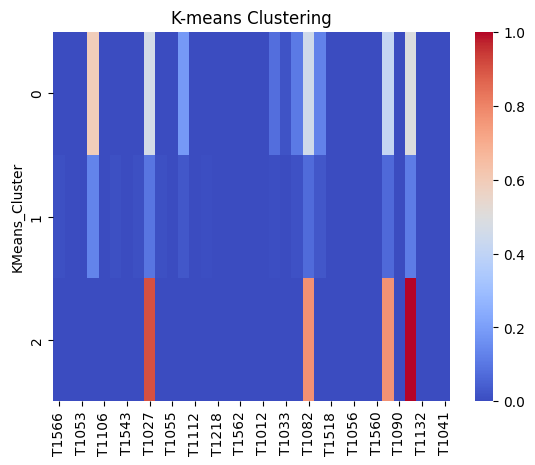

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)  # You can choose the number of clusters
kmeans.fit(df)
df['KMeans_Cluster'] = kmeans.labels_

silhouette_kmeans = silhouette_score(df, kmeans.labels_)
# Visualize the clusters using a heatmap
sns.heatmap(df.groupby('KMeans_Cluster').mean(), cmap='coolwarm')
plt.title('K-means Clustering')
plt.show()

df = df.drop(columns='KMeans_Cluster')

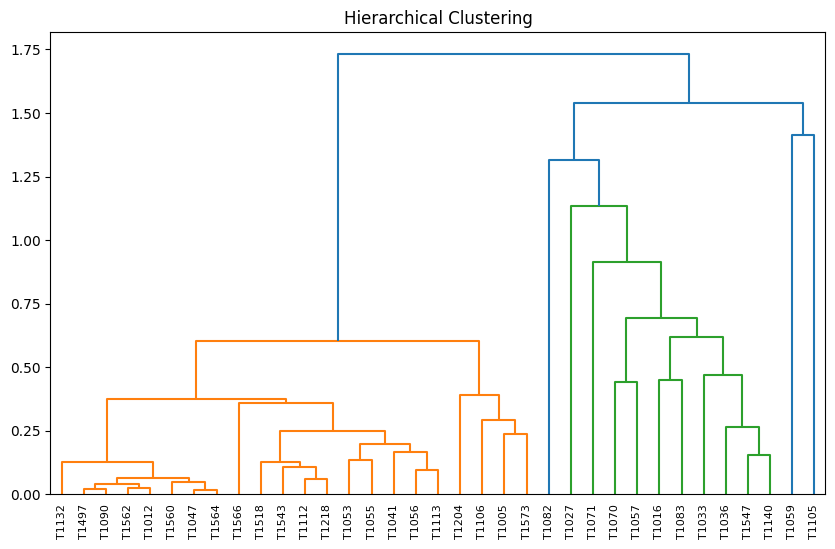

In [8]:
# Apply hierarchical clustering
linkage = hierarchy.linkage(df, method='complete', metric='euclidean')

# Visualize the clusters using a dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage, labels=df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering')
plt.show()

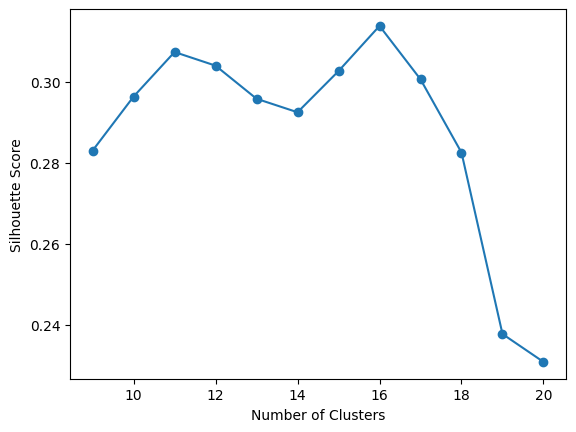

In [9]:
k_values = [9,10,11,12,13,14,15,16,17,18,19,20]
silhouette_scores = []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k)
    df_cluster['agg'] = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, df_cluster['agg'])
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [10]:
# Perform Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=16)
agg_labels = agg.fit_predict(df)
silhouette_agg = silhouette_score(df, agg_labels)

In [11]:
# Calculate Jaccard distance
def jaccard_distance(a, b):
  intersection = len(set(a).intersection(b))
  union = len(set(a).union(b))
  return 1 - (intersection / union)

# Calculate Spearman correlation distance
def spearman_distance(a, b):
  return np.abs(np.corrcoef(a, b)[0, 1])

In [12]:
#PAM (Partitioning Around Medoids)
def pam_clustering(data, distance_metric, k):
  """
  Performs PAM clustering on the given data using the specified distance metric.

  Args:
      data (pandas.DataFrame): The data to be clustered.
      distance_metric (function): A function that calculates the distance between two data points.
      k (int): The desired number of clusters.

  Returns:
      list: A list of cluster labels for each data point.
  """

  # Convert data to a list of lists
  data_list = data.values.tolist()

  # Calculate distance matrix using the chosen metric
  distance_matrix = []
  for i in range(len(data_list)):
    row = []
    for j in range(len(data_list)):
      distance = distance_metric(data_list[i], data_list[j])
      row.append(distance)
    distance_matrix.append(row)

  # Perform PAM clustering
  initial_medoids = np.random.choice(range(len(data_list)), k, replace=False)
  kmedoids_instance = kmedoids(distance_matrix, n_clusters=k, initial_index_medoids=initial_medoids, data_type='distance_matrix')
  kmedoids_instance.process()
  cluster_labels = kmedoids_instance.predict(data_list)
  return cluster_labels

# Perform PAM clustering with Jaccard distance
jaccard_labels = pam_clustering(df.copy(), jaccard_distance, k=3)  # Replace 3 with your desired number of clusters

# Perform PAM clustering with Spearman correlation distance
spearman_labels = pam_clustering(df.copy(), spearman_distance, k=3)  # Replace 3 with your desired number of clusters



In [13]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.decomposition import PCA

init_notebook_mode(connected=True)

def plotly_clusters(data, labels, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    unique_labels = np.unique(labels)
    data = []
    
    for i, label in enumerate(unique_labels):
        cluster_data = reduced_data[labels == label]
        trace = go.Scatter(
            x = cluster_data[:, 0],
            y = cluster_data[:, 1],
            mode = 'markers',
            name = f'Cluster {label + 1}',
            marker = dict(
                size = 10,
                line = dict(
                    width = 2,
                ),
                opacity = 0.8
            )
        )
        data.append(trace)
        
    layout = go.Layout(
        title = title,
        xaxis = dict(title = 'PCA 1'),
        yaxis = dict(title = 'PCA 2'),
        margin = dict(l = 0, r = 0, t = 40, b = 30)
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

# Assuming df is your dataframe, and you have jaccard_labels and spearman_labels obtained from your clustering
# First, prepare your dataframe by excluding any non-numeric columns if present
df_numeric = df.select_dtypes(include=[np.number])

# Visualization for Jaccard Distance
plotly_clusters(df_numeric, np.array(jaccard_labels), 'PAM Clustering with Jaccard Distance')

# Visualization for Spearman Correlation Distance
plotly_clusters(df_numeric, np.array(spearman_labels), 'PAM Clustering with Spearman Correlation Distance')



In [17]:
!pip install --force-reinstall numpy



  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.


In [18]:
k_values = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_scores_fuzzy = []

for k in k_values:
    # Initialize K-means plus plus centers
    initial_centers = kmeans_plusplus_initializer(df.values.tolist(), k).initialize()

    # Perform X-Means clustering
    xmeans_instance = xmeans.xmeans(df.values.tolist(), initial_centers, ccore=True)
    xmeans_instance.process()

    # Extract cluster labels
    cluster_labels = xmeans_instance.get_clusters()

    # Calculate silhouette score
    silhouette_avg = silhouette_score(df, xmeans_instance.predict(df.values.tolist()))
    silhouette_scores_fuzzy.append(silhouette_avg)

AttributeError: module 'numpy' has no attribute 'warnings'

In [19]:
k_values = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_scores_divisive = []

for k in k_values:
    # Initialize K-means plus plus centers
    initial_centers = kmeans_plusplus_initializer(df.values.tolist(), k).initialize()

    # Perform K-Means clustering
    kmeans_instance = kmeans.kmeans(df.values.tolist(), initial_centers)
    kmeans_instance.process()

    # Extract cluster labels
    cluster_labels = kmeans_instance.get_clusters()

    # Calculate silhouette score
    silhouette_avg = silhouette_score(df, kmeans_instance.predict(df.values.tolist()))
    silhouette_scores_divisive.append(silhouette_avg)

AttributeError: module 'numpy' has no attribute 'warnings'

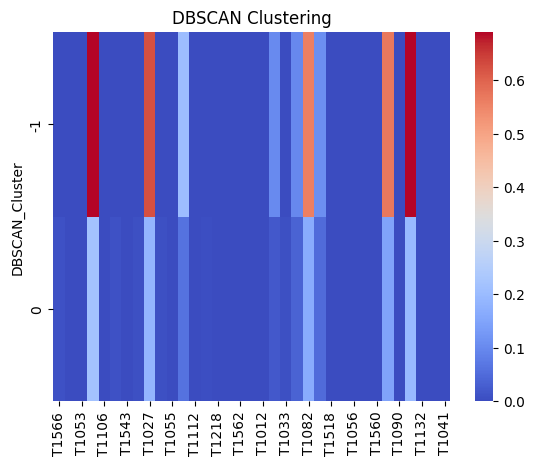

In [20]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)
df['DBSCAN_Cluster'] = dbscan_labels
#silhouette_dbscan = silhouette_score(df, dbscan_labels[dbscan_labels != -1])
# Visualize the clusters using a heatmap
sns.heatmap(df.groupby('DBSCAN_Cluster').mean(), cmap='coolwarm')
plt.title('DBSCAN Clustering')
plt.show()
df = df.drop(columns='DBSCAN_Cluster')

In [21]:
# Compare silhouette scores
print("Silhouette Score - KMeans:", silhouette_kmeans)
print("Silhouette Score - Agglomerative Clustering:", silhouette_agg)
#print("Silhouette Score - DBSCAN:", silhouette_dbscan)

Silhouette Score - KMeans: 0.6652322569247743
Silhouette Score - Agglomerative Clustering: 0.3138638552324883


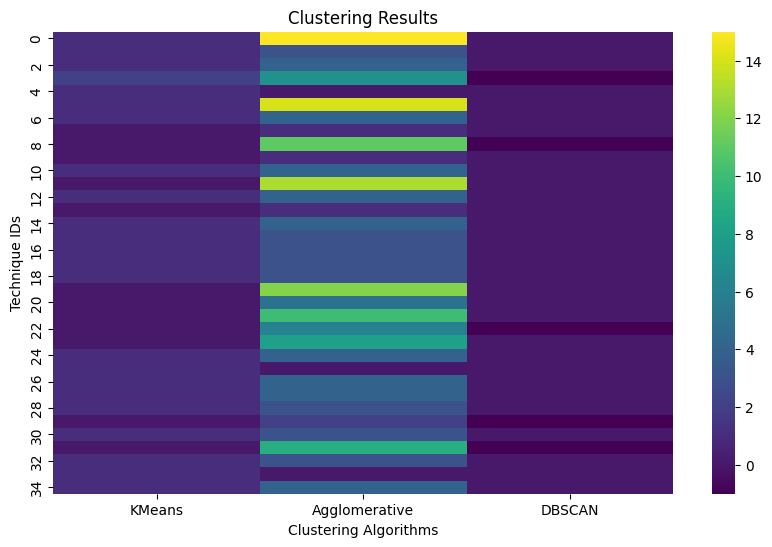

In [22]:

# Create a DataFrame with the clustering labels
clustered_df = pd.DataFrame({'KMeans': kmeans.labels_,
                             'Agglomerative': agg_labels,
                             'DBSCAN': dbscan_labels})

# Plot the clustered DataFrame as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(clustered_df, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Clustering Algorithms')
plt.ylabel('Technique IDs')
plt.show()

In [5]:
!python -V
!pip --version

Python 3.12.2
pip 24.0 from C:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\pip (python 3.12)



Sequential Rule mining

In [17]:
def find_frequent_patterns(df):
    frequent_patterns = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Iterate over each column in the row
        for column, value in row.items():
            # If the value is greater than 0.5, consider it as a frequent item
            if value > 0.5:
                # Append the item to the frequent patterns list along with its count
                frequent_patterns.append(((column, index), value))
    
    # Sort the frequent patterns in increasing order of count
    frequent_patterns.sort(key=lambda x: x[1])
    
    return frequent_patterns

# Perform sequential pattern mining
patterns = find_frequent_patterns(df)

# Print discovered sequential patterns with count > 0.5
for pattern, count in patterns:
    print(f"Pattern: {pattern}, Count: {count}")


Pattern: ('T1082', 'T1016'), Count: 0.502202643
Pattern: ('T1016', 'T1082'), Count: 0.502202643
Pattern: ('T1105', 'T1083'), Count: 0.515418502
Pattern: ('T1027', 'T1140'), Count: 0.524229075
Pattern: ('T1105', 'T1070'), Count: 0.528634361
Pattern: ('T1059', 'T1083'), Count: 0.528634361
Pattern: ('T1070', 'T1027'), Count: 0.546255507
Pattern: ('T1027', 'T1070'), Count: 0.546255507
Pattern: ('T1083', 'T1082'), Count: 0.546255507
Pattern: ('T1082', 'T1083'), Count: 0.546255507
Pattern: ('T1071', 'T1082'), Count: 0.594713656
Pattern: ('T1082', 'T1071'), Count: 0.594713656
Pattern: ('T1059', 'T1070'), Count: 0.607929515
Pattern: ('T1082', 'T1027'), Count: 0.651982379
Pattern: ('T1027', 'T1082'), Count: 0.651982379
Pattern: ('T1071', 'T1027'), Count: 0.691629956
Pattern: ('T1027', 'T1071'), Count: 0.691629956
Pattern: ('T1071', 'T1059'), Count: 0.766519824
Pattern: ('T1059', 'T1071'), Count: 0.766519824
Pattern: ('T1082', 'T1059'), Count: 0.77092511
Pattern: ('T1059', 'T1082'), Count: 0.770